####  **Import Required Libraries**

In [701]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib

####  **Load Prepared Data**

In [702]:
file_path = "../resources/data/output/customer_churn_with_predicted_clv.csv" 
df = pd.read_csv(file_path)

#### **Feature Engineering**

In [703]:
# Create new binary feature: 1 = active, 0 = non-active
df["status_active"] = df["status"].apply(lambda x: 1 if x == 1 else 0)

In [704]:
df.head()

,call_failure,complains,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn,predicted_clv,status_active
0,8,0,0,4370,5,17,3,1,1,197.640,0,186.429207,1
1,0,0,0,318,7,4,2,1,2,46.035,0,36.197297,0
2,10,0,0,2453,359,24,3,1,1,1536.520,0,1559.810804,1
3,10,0,0,4198,1,35,1,1,1,240.020,0,249.052453,1
4,3,0,0,2393,2,33,1,1,1,145.805,0,142.848381,1


In [705]:
X = df.drop(columns=["churn", "status"])

In [706]:
X.columns

Index(['call_failure', 'complains', 'charge_amount', 'seconds_of_use',
       'frequency_of_SMS', 'distinct_called_numbers', 'age_group',
       'tariff_plan', 'customer_value', 'predicted_clv', 'status_active'],
      dtype='object')

#### **Numeric and Categorical features**

In [707]:
numeric_features = [
    "call_failure",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "status_active"
]
categorical_features = [ "tariff_plan", "age_group"]

####  **Target feature**

In [708]:
y = df["churn"]

#### **Function to train and evaluate model**

In [709]:
def train_logistic(X, y, num_f, cat_f, label="Model"):
    # 1. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2. Preprocessor
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_f),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore'), cat_f)
    ])

    # 3. Full Pipeline with SMOTE
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", LogisticRegression(max_iter=1000))
    ])

    # 4. Train
    pipeline.fit(X_train, y_train)

    # 5. Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # 6. Evaluation
    print(f"\nClassification Report ({label} + SMOTE):")
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

    # 7. Extract feature names (after fit)
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
    if cat_f:
        cat_feature_names = ohe.get_feature_names_out(cat_f)
    else:
        cat_feature_names = []
    all_feature_names = list(num_f) + list(cat_feature_names)

    # 8. Get coefficients
    model = pipeline.named_steps["classifier"]
    coef_df = pd.DataFrame({
        "Feature": all_feature_names,
        "Coefficient": model.coef_.flatten()
    }).sort_values(by="Coefficient", key=abs, ascending=False)

    return pipeline, y_test, y_prob, coef_df

#### **A) With actual CLV**

In [710]:
numeric_features_a = numeric_features + ["customer_value"]
X_a = X[numeric_features_a + categorical_features]

In [711]:
model_a, y_test_a, y_prob_a, coef_df_a = train_logistic(
    X_a, 
    y, 
    numeric_features_a, 
    categorical_features, 
    label="Using Actual CLV"
)


Classification Report (Using Actual CLV + SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       473
           1       0.44      0.75      0.55        80

    accuracy                           0.82       553
   macro avg       0.69      0.79      0.72       553
weighted avg       0.88      0.82      0.84       553

AUC Score: 0.9237


#### **B) With predicted CLV**

In [712]:
numeric_features_b = numeric_features + ["predicted_clv"]
X_b = X[numeric_features_b + categorical_features]

In [713]:
model_b, y_test_b, y_prob_b, coef_df_b = train_logistic(
    X_b,
    y,
    numeric_features_b,
    categorical_features,
    label="Using Predicted CLV"
)



Classification Report (Using Predicted CLV + SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       473
           1       0.45      0.78      0.57        80

    accuracy                           0.83       553
   macro avg       0.70      0.81      0.73       553
weighted avg       0.88      0.83      0.85       553

AUC Score: 0.9243


#### **ROC Curve Comparison**

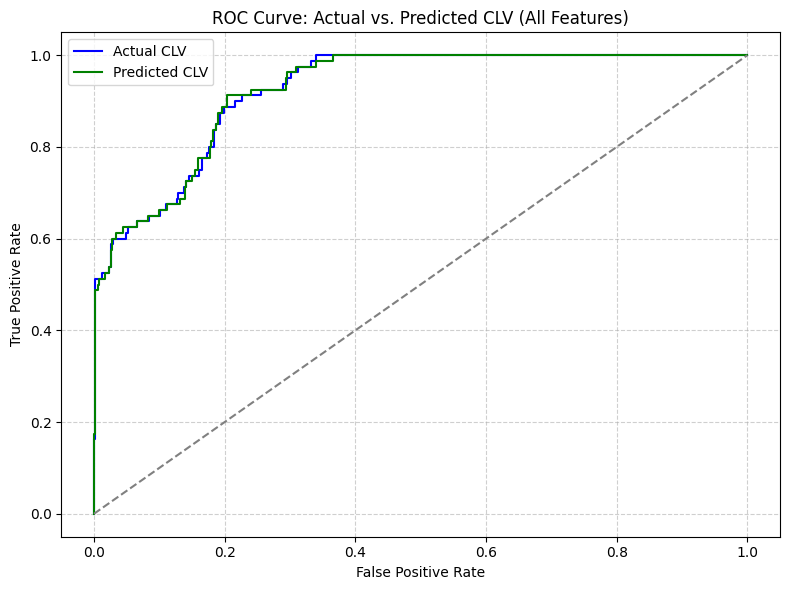

In [714]:
fpr_a, tpr_a, _ = roc_curve(y_test_a, y_prob_a)
fpr_b, tpr_b, _ = roc_curve(y_test_b, y_prob_b)

plt.figure(figsize=(8, 6))
plt.plot(fpr_a, tpr_a, label="Actual CLV", color="blue")
plt.plot(fpr_b, tpr_b, label="Predicted CLV", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Actual vs. Predicted CLV (All Features)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#### **actual CLV** vs **predicted CLV**


| Metric       | Using Actual CLV | Using Predicted CLV |
|--------------|------------------|----------------------|
| Accuracy     | 82%              | 83%              |
| Recall (Class 1 - Churn) | 75%         | 78%            |
| F1-Score (Class 1) | 0.55         | 0.56              |
| AUC Score    | 0.9237           | 0.9244            |


- Both models demonstrate strong performance in predicting churn, with very similar overall accuracy and AUC.
- Predicted CLV performs slightly better across all key metrics:
  - +1% higher accuracy
  - Higher recall (more true churners detected)
  - Slightly better F1-score
  - Marginally improved AUC
- This suggests that the regression-predicted CLV can effectively substitute actual CLV in scenarios where true CLV isn’t directly available.

#### **Cross-Validation with SMOTE**

In [715]:
def evaluate_logistic_pipeline_cv(X, y, num_f, cat_f, clv_label="Actual CLV", k=5):
    # Preprocessor
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_f),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_f)
    ])

    # Full pipeline with SMOTE
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", LogisticRegression(max_iter=1000))
    ])

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Evaluate with multiple metrics
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=skf,
        scoring=["roc_auc", "recall", "f1"],
        return_train_score=False
    )

    # Print fold results
    for i in range(k):
        print(f"\n Fold {i+1} | AUC: {scores['test_roc_auc'][i]:.4f} | Recall: {scores['test_recall'][i]:.4f} | F1: {scores['test_f1'][i]:.4f}")

    # Print average scores
    print(f"\n {k}-Fold Cross-Validation Results ({clv_label}):")
    print(f"Average AUC:    {np.mean(scores['test_roc_auc']):.4f}")
    print(f"Average Recall: {np.mean(scores['test_recall']):.4f}")
    print(f"Average F1:     {np.mean(scores['test_f1']):.4f}")
    return pipeline

In [716]:
cv_pipeline_a = evaluate_logistic_pipeline_cv(X_a, y, num_f=numeric_features_a, cat_f=categorical_features, clv_label="Using Actual CLV")


 Fold 1 | AUC: 0.9227 | Recall: 0.8000 | F1: 0.5981

 Fold 2 | AUC: 0.9152 | Recall: 0.8000 | F1: 0.5590

 Fold 3 | AUC: 0.9210 | Recall: 0.8375 | F1: 0.5877

 Fold 4 | AUC: 0.9537 | Recall: 0.9012 | F1: 0.6348

 Fold 5 | AUC: 0.9411 | Recall: 0.8395 | F1: 0.6210

 5-Fold Cross-Validation Results (Using Actual CLV):
Average AUC:    0.9307
Average Recall: 0.8356
Average F1:     0.6001


In [717]:
cv_pipeline_b = evaluate_logistic_pipeline_cv(X_b, y, num_f=numeric_features_b, cat_f=categorical_features, clv_label="Using Predicted CLV")


 Fold 1 | AUC: 0.9247 | Recall: 0.8250 | F1: 0.6000

 Fold 2 | AUC: 0.9153 | Recall: 0.8125 | F1: 0.5603

 Fold 3 | AUC: 0.9230 | Recall: 0.8250 | F1: 0.5764

 Fold 4 | AUC: 0.9542 | Recall: 0.9136 | F1: 0.6435

 Fold 5 | AUC: 0.9423 | Recall: 0.8395 | F1: 0.6154

 5-Fold Cross-Validation Results (Using Predicted CLV):
Average AUC:    0.9319
Average Recall: 0.8431
Average F1:     0.5991


In [718]:
def interpret_logistic_model(coef_df, title="Feature Impact on Churn"):
    coef_df = coef_df.sort_values("Coefficient")

    # Compute odds ratio
    coef_df["Odds Ratio"] = np.exp(coef_df["Coefficient"])

    # Bar colors
    color_palette = coef_df["Coefficient"].apply(lambda x: "#D62728" if x > 0 else "#2CA02C")

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=coef_df["Coefficient"],
        y=coef_df["Feature"],
        orient="h"
    )

    # Color bars
    for bar, color in zip(ax.patches, color_palette):
        bar.set_facecolor(color)
        bar.set_edgecolor("black")

    # Annotate with odds ratio
    for i, (_, row) in enumerate(coef_df.iterrows()):
        coef = row["Coefficient"]
        odds = row["Odds Ratio"]
        x_pos = coef + 0.1 if coef > 0 else coef - 0.1
        ha = 'left' if coef > 0 else 'right'
        ax.text(x_pos, i, f"OR: {odds:.2f}", va='center', ha=ha, fontsize=9, color='black')

    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.title(title, fontsize=13)
    plt.xlabel("Coefficient (Effect on Churn)")
    plt.ylabel("Feature")
    plt.grid(axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()



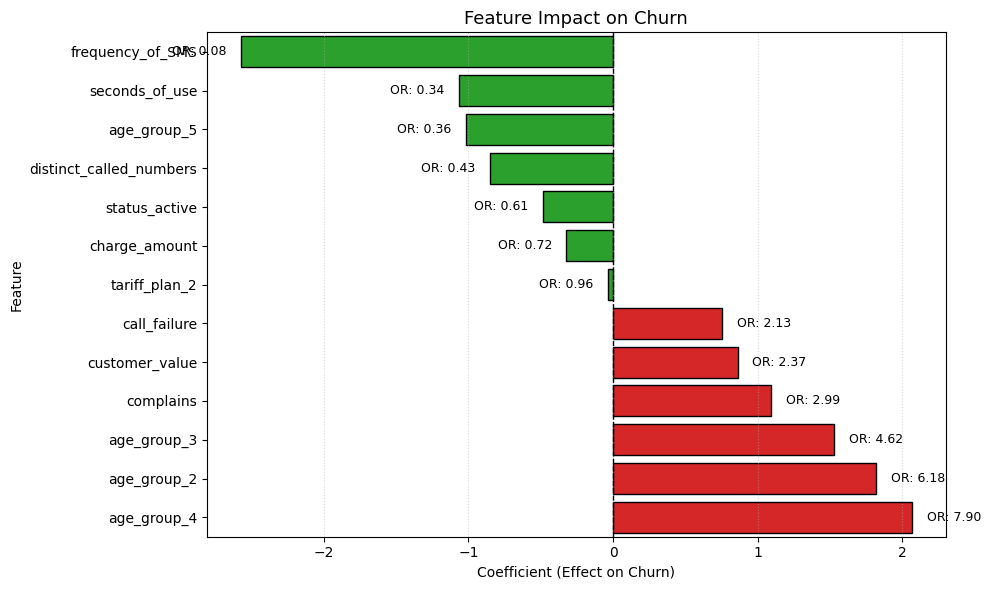

In [720]:
interpret_logistic_model(coef_df_a)

**Features increasing churn risk (red bars):**

- Age group 4 has the highest impact (OR: 7.90), making customers in this group nearly 8 times more likely to churn
- Age group 2 (OR: 6.18) and Age group 3 (OR: 4.62) also significantly increase churn risk
- Customers who complain (OR: 2.99), have high customer value (OR: 2.37), and experience call failures (OR: 2.13) are more likely to churn

**Features decreasing churn risk (green bars):**

- Higher frequency of SMS (OR: 0.08) strongly reduces churn risk
- More seconds of use (OR: 0.34), age group 5 (OR: 0.36), and higher distinct called numbers (OR: 0.43) all decrease churn probability
- Active status (OR: 0.61), charge amount (OR: 0.72), and tariff plan 2 (OR: 0.96) have moderate protective effects against churn

In [725]:
X_a.shape

(2765, 10)

In [736]:
# After CV
final_pipeline = cv_pipeline_a.fit(X_a, y)

# Extract components
preprocessor = final_pipeline.named_steps["preprocessor"]
classifier = final_pipeline.named_steps["classifier"]
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_features = list(numeric_features_a) + list(cat_features)

coef_df_cv_a = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": classifier.coef_[0],
    "Odds Ratio": np.exp(classifier.coef_[0])
}).sort_values(by="Coefficient", key=abs, ascending=False)

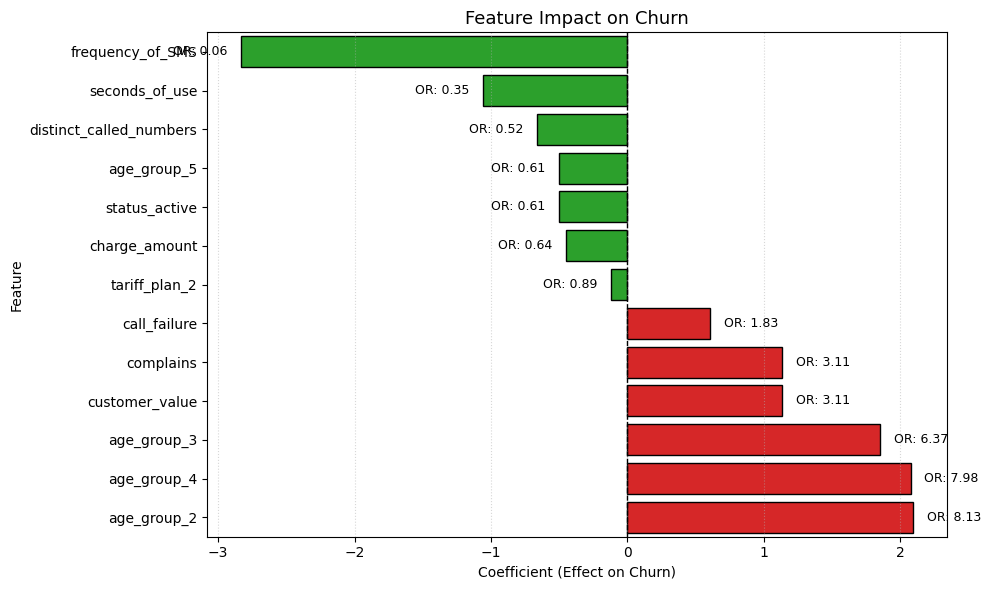

In [737]:
interpret_logistic_model(coef_df_cv_a)

#### **Assessing the Role of `customer_value (CLV)` in Churn Prediction**

Since `customer_value` has a positive coefficient, it implies that a higher CLV drives a higher churn probability, which contradicts business sense because high-value customers are expected to stay. We will assess the impact of `customer_value` on predicting churn.

##### Logistic Regression with Only customer_value

In [742]:
numeric_features_only_clv = ["customer_value"]
categorical_features = []

X_only_clv = X[numeric_features_only_clv + categorical_features]
X_only_clv.head()

,customer_value
0,197.640
1,46.035
2,1536.520
3,240.020
4,145.805


In [743]:
_, y_test_only_clv, y_prob_only_clv, _ = train_logistic(
    X_only_clv, 
    y, 
    numeric_features_only_clv, 
    categorical_features, 
    label="Role of customer_value"
)


Classification Report (Role of customer_value + SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.54      0.69       473
           1       0.24      0.85      0.37        80

    accuracy                           0.58       553
   macro avg       0.60      0.69      0.53       553
weighted avg       0.85      0.58      0.64       553

AUC Score: 0.7505


In [744]:
evaluate_logistic_pipeline_cv(X_only_clv, y, num_f=numeric_features_only_clv, cat_f=categorical_features, clv_label="Role of customer_value")


 Fold 1 | AUC: 0.7616 | Recall: 0.8250 | F1: 0.3697

 Fold 2 | AUC: 0.7626 | Recall: 0.8500 | F1: 0.3646

 Fold 3 | AUC: 0.7444 | Recall: 0.7875 | F1: 0.3481

 Fold 4 | AUC: 0.7896 | Recall: 0.8765 | F1: 0.3890

 Fold 5 | AUC: 0.7997 | Recall: 0.9383 | F1: 0.4108

 5-Fold Cross-Validation Results (Role of customer_value):
Average AUC:    0.7716
Average Recall: 0.8555
Average F1:     0.3765


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_value']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=1000))])

#### Logistic Regression with All Features Except `customer_value`


In [745]:
X_excl_clv = X[numeric_features + categorical_features]

X_excl_clv.head()

,call_failure,complains,seconds_of_use,frequency_of_SMS,distinct_called_numbers,charge_amount,status_active
0,8,0,4370,5,17,0,1
1,0,0,318,7,4,0,0
2,10,0,2453,359,24,0,1
3,10,0,4198,1,35,0,1
4,3,0,2393,2,33,0,1


In [746]:
_, y_test_excl_clv, y_prob_excl_clv, _ = train_logistic(
    X_excl_clv, 
    y, 
    numeric_features, 
    categorical_features, 
    label="Role of all features except customer_value"
)


Classification Report (Role of all features except customer_value + SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       473
           1       0.43      0.71      0.54        80

    accuracy                           0.82       553
   macro avg       0.69      0.78      0.71       553
weighted avg       0.87      0.82      0.84       553

AUC Score: 0.9226


In [747]:
evaluate_logistic_pipeline_cv(X_excl_clv, y, num_f=numeric_features, cat_f=categorical_features, clv_label="Role of all features except customer_value")


 Fold 1 | AUC: 0.9206 | Recall: 0.8000 | F1: 0.6066

 Fold 2 | AUC: 0.9127 | Recall: 0.7750 | F1: 0.5586

 Fold 3 | AUC: 0.9226 | Recall: 0.8250 | F1: 0.5841

 Fold 4 | AUC: 0.9548 | Recall: 0.9012 | F1: 0.6404

 Fold 5 | AUC: 0.9376 | Recall: 0.8272 | F1: 0.6204

 5-Fold Cross-Validation Results (Role of all features except customer_value):
Average AUC:    0.9297
Average Recall: 0.8257
Average F1:     0.6020


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['call_failure', 'complains',
                                                   'seconds_of_use',
                                                   'frequency_of_SMS',
                                                   'distinct_called_numbers',
                                                   'charge_amount',
                                                   'status_active']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=1000))])

##### Model Performance Comparison



| Model Variant                              | Accuracy | Recall (Churn) | F1 (Churn) | AUC Score |
|--------------------------------------------|----------|----------------|------------|-----------|
| Only customer_value                 | 0.58     | 0.85       | 0.37       | 0.7505 |
| All features except customer_value   | 0.82     | 0.71           | 0.54       | 0.9226    |
| All features including customer_value| 0.82     | 0.75           | 0.55       | 0.9237 |


**Conclusion: Role of customer_value in Churn Prediction**

- customer_value alone captures some signal (AUC = 0.75) but performs poorly in precision and overall accuracy.
- The model using all original features (without CLV) performs very well, achieving high recall and AUC.
- Adding customer_value to the full model gives only a minor AUC improvement (from 0.9226 → 0.9237) and slightly better recall, showing limited incremental benefit.

**Insight:** While customer_value has predictive power, it appears redundant when used alongside features that were originally used to compute it. It contributes minimal additional value in the presence of its source features.
